In [42]:
import os, json, pickle, inspect
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler
from sklearn.model_selection import train_test_split

import utils
import commons
import models
from cough_datasets import CoughDatasets, CoughDatasetsCollate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score

from tensorboard.backend.event_processing import event_accumulator

import warnings
warnings.simplefilter("ignore", UserWarning)

# =============================================================
# SECTION: Intialize Data
# =============================================================
INIT = False
MODEL_NAME = "try_lstm_sken3_exludedf_issue"
CONFIG_PATH = "configs/lstm_cnn.json"

model_dir = os.path.join("./logs", MODEL_NAME)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

config_save_path = os.path.join(model_dir, "config.json")
if INIT:
    with open(CONFIG_PATH, "r") as f:
      data = f.read()
    with open(config_save_path, "w") as f:
      f.write(data)
else:
    with open(config_save_path, "r") as f:
      data = f.read()

config = json.loads(data)
  
hps = utils.HParams(**config)
hps.model_dir = model_dir

BATCH_SIZE = hps.train.batch_size
ACCUMULATION_STEP = hps.train.accumulation_steps
assert (ACCUMULATION_STEP > 0) and (BATCH_SIZE % ACCUMULATION_STEP == 0)
cur_bs = BATCH_SIZE // ACCUMULATION_STEP

# =============================================================
# SECTION: Loading Data
# =============================================================

##### Label Umum Semua
Diseases_codes = [0, 1]
CLASS_NAMES = ["Negative TB", "Positive TB"]

df = pd.read_csv(f'{hps.data.db_path}/{hps.data.metadata_csv}')
df = df[df['cough_score'] >= 0.90].sample(frac=1, random_state=40)

df_solic = df[df['type_cough'] == 0].sample(frac=1, random_state=41)
df_solic['path_file'] = hps.data.db_path + df_solic['path_file']

In [43]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.signal import welch
import os

# Example: use your DataFrame here
# df = pd.read_csv("your_df.csv")

# Create output directories (optional)
os.makedirs("psd_results", exist_ok=True)
os.makedirs("fft_results", exist_ok=True)

for count, row in df_solic.iterrows():
    wav_path = row['path_file']
    label = row['disease_label']

    try:
        # Load WAV
        sample_rate, data = wavfile.read(wav_path)

        desired_length = 8000  # e.g., 2 sec at 16kHz

        if len(data) > desired_length:
            data = data[:desired_length]
        else:
            data = np.pad(data, (0, desired_length - len(data)))

        # Handle stereo
        if len(data.shape) == 2:
            data = data[:, 0]

        # Normalize to [-1, 1] if int type
        if np.issubdtype(data.dtype, np.integer):
            data = data / np.iinfo(data.dtype).max

        max_val = np.max(np.abs(data))
        if max_val > 0:
            data = data / max_val

        # ----- PSD -----
        freqs_psd, psd = welch(data, fs=sample_rate, nperseg=1024)
        psd_save_path = f"psd_results/psd_{label}_{count}.npy"
        np.save(psd_save_path, psd)

        # ----- FFT -----
        N = len(data)
        fft_result = np.fft.fft(data)
        fft_magnitude = np.abs(fft_result[:N // 2])  # Keep only positive freqs
        fft_save_path = f"fft_results/fft_{label}_{count}.npy"
        np.save(fft_save_path, fft_magnitude)

    except Exception as e:
        print(f"Error processing index {count} ({wav_path}): {e}")


In [44]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

# Collect results grouped by disease
psd_group = defaultdict(list)
fft_group = defaultdict(list)

for count, row in df_solic.iterrows():
    label = row['disease_label']
    
    # Load saved PSD and FFT
    psd_path = f"psd_results/psd_{label}_{count}.npy"
    fft_path = f"fft_results/fft_{label}_{count}.npy"
    
    try:
        psd = np.load(psd_path)
        fft = np.load(fft_path)
        
        psd_group[label].append(psd)
        fft_group[label].append(fft)
    
    except Exception as e:
        print(f"Skipping {label}_{count}: {e}")

# Compute mean per label and save
os.makedirs("mean_results", exist_ok=True)

for label in psd_group:
    psd_stack = np.stack(psd_group[label])
    fft_stack = np.stack(fft_group[label])

    psd_mean = np.mean(psd_stack, axis=0)
    fft_mean = np.mean(fft_stack, axis=0)

    # Save means
    np.save(f"mean_results/psd_mean_label{label}.npy", psd_mean)
    np.save(f"mean_results/fft_mean_label{label}.npy", fft_mean)

    print(f"Saved mean PSD and FFT for label {label}")


Saved mean PSD and FFT for label 0
Saved mean PSD and FFT for label 1


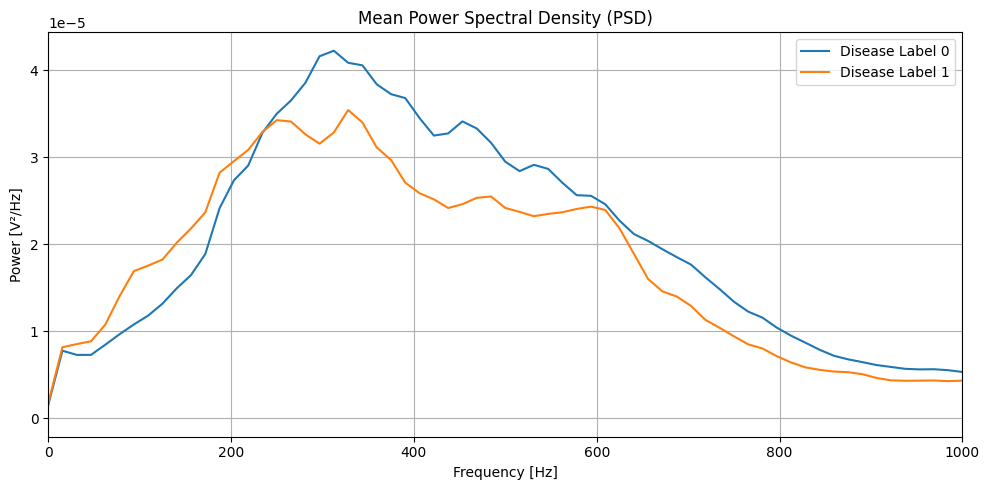

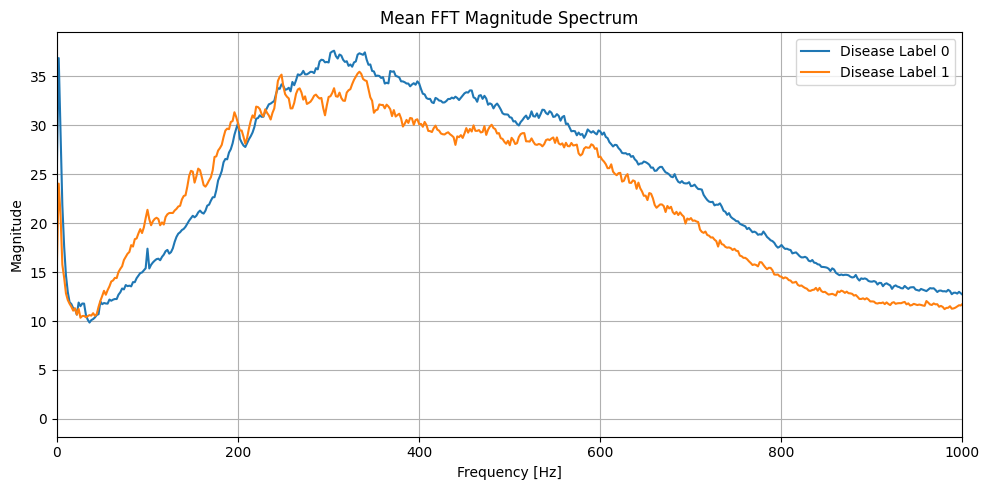

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Load PSD and FFT means
psd_0 = np.load("mean_results/psd_mean_label0.npy")
psd_1 = np.load("mean_results/psd_mean_label1.npy")

fft_0 = np.load("mean_results/fft_mean_label0.npy")
fft_1 = np.load("mean_results/fft_mean_label1.npy")

# Estimate frequency axes
# PSD: same as welch(..., nperseg=1024), so 512 bins if fs was typical audio rate (e.g. 16000 Hz)
sample_rate = 16000  # adjust if different
nperseg = 1024
psd_freqs = np.linspace(0, sample_rate / 2, len(psd_0))
fft_freqs = np.linspace(0, sample_rate / 2, len(fft_0))

# ---- Plot PSD ----
plt.figure(figsize=(10, 5))
plt.plot(psd_freqs, psd_0, label="Disease Label 0")
plt.plot(psd_freqs, psd_1, label="Disease Label 1")
plt.title("Mean Power Spectral Density (PSD)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [V²/Hz]")
plt.xlim(0, 1000)  # Limit to 2000 Hz
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot FFT ----
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_0, label="Disease Label 0")
plt.plot(fft_freqs, fft_1, label="Disease Label 1")
plt.title("Mean FFT Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 1000)  # Limit to 2000 Hz
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
